## Evaluation

In [40]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

# Shut up RDKit
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw


In [206]:
sys.path.append('./SD_LSTM/')
sys.path.append('./LSTM/')
sys.path.append('./VANILLA_VAE/')
sys.path.append('./SD_VAE/')

from sd_vae_sampler import SDVAESampler
from model_sd_vae import SDVAE
from sd_lstm_sampler import SDLSTMSampler
from sd_lstm_utils import load_model as load_sd_lstm_model
from benchmark_vanilla_vae import VanillaVAEHarness
from model_vanilla_vae import VanillaMolVAE
from rnn_utils import load_model

from fast_rnn_sampler import FastSampler
# from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model


sys.path.append('utils/')

from evaluation_utils import amina_metrics, property_metrics, props_from_smiles, plot_smiles

In [44]:
sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])

In [205]:
# Clear modules cache
'''
del sys.modules['evaluation_utils']
import importlib
importlib.invalidate_caches()
'''


### Load Models

In [8]:
# Load SD-LSTM Model


sd_lstm_model_path = "models/SD_LSTM_QM9_MASKED_CROSS_ENTROPY_TOKENS/"
sd_lstm_weights_fname = "SD_LSTM_dark-hall-89_Epoch_37_Vl_0.199.pt"
sd_lstm_definition_fname = "SD_LSTM_dark-hall-89_Epoch_37_Vl_0.199.json"

sd_lstm_sampler = SDLSTMSampler(device = 'cpu', rules_dict_size = 80, batch_size=64)
sd_lstm_model = load_sd_lstm_model(
            model_definition= os.path.join(sd_lstm_model_path, sd_lstm_definition_fname),
            model_weights = os.path.join(sd_lstm_model_path, sd_lstm_weights_fname),
            device = 'cpu',
            )

with open(os.path.join(sd_lstm_model_path, sd_lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

sd_lstm_mpar = model_params['property_names']
print(f'SD-LSTM Conditioned on Following Props: {sd_lstm_mpar}')

SD-LSTM Conditioned on Following Props: ['LogP']


In [9]:
# Load LSTM Model

lstm_model_path = "models/LSTM_QM9/batch_size_20_2"
lstm_weights_fname = "LSTM_8_1.151.pt"
lstm_definition_fname = "LSTM_8_1.151.json"


lstm_sampler = FastSampler(device = 'cpu', batch_size=64)
lstm_model = load_rnn_model(
            model_definition= os.path.join(lstm_model_path, lstm_definition_fname),
            model_weights = os.path.join(lstm_model_path, lstm_weights_fname),
            device = 'cpu',
            )
    
with open(os.path.join(lstm_model_path, lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

lstm_mpar = model_params['property_names']
print(f'cLSTM Conditioned on Following Props: {lstm_mpar}')

cLSTM Conditioned on Following Props: ['LogP']


In [219]:
# Load Vanilla VAE Model
model_weights = 'models/VANILLA_VAE_QM9/SD_LSTM_tiny-pond-31_Epoch_71_Vl_0.354.pt'
model_definit = 'models/VANILLA_VAE_QM9/SD_LSTM_tiny-pond-31_Epoch_71_Vl_0.354.json'

vae_sampler = VanillaVAEHarness(batch_size=64, device='cpu')
vae_model = load_model(model_class=VanillaMolVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

with open(os.path.join(lstm_model_path, lstm_definition_fname)) as pfile:
    vae_model_params = json.load(pfile)

vae_mpar = vae_model_params['property_names']
print(f'cLSTM Conditioned on Following Props: {lstm_mpar}')


a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
cLSTM Conditioned on Following Props: ['LogP']


In [225]:
# Load SD VAE Model
# Load Vanilla VAE Model
model_weights = 'models/SD_VAE_MASKED_BIN_CE/SD_LSTM_shiny-shape-08_Epoch_81_Vl_0.122.pt'
model_definit = 'models/SD_VAE_MASKED_BIN_CE/SD_LSTM_shiny-shape-08_Epoch_81_Vl_0.122.json'

sd_vae_sampler = SDVAESampler(batch_size=64, device='cpu')
sd_vae_model = load_model(model_class=SDVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

with open(os.path.join(lstm_model_path, lstm_definition_fname)) as pfile:
    sd_vae_model_params = json.load(pfile)

sd_vae_mpar = sd_vae_model_params['property_names']
print(f'cLSTM Conditioned on Following Props: {sd_vae_mpar}')


a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
cLSTM Conditioned on Following Props: ['LogP']


In [12]:
sd_lstm_sampler.sample(model=sd_lstm_model, properties=torch.Tensor([[-3.0], [-3.5]]), num_to_sample = 2, max_seq_len=100)

['COCC([NH3+])C(=O)[O-]', 'CC([NH3+])C1(O)C(O)C1O']

# Dataset

In [45]:
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/QM9/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


### Target Property Distributions

In [46]:
prop_names = ['LogP']

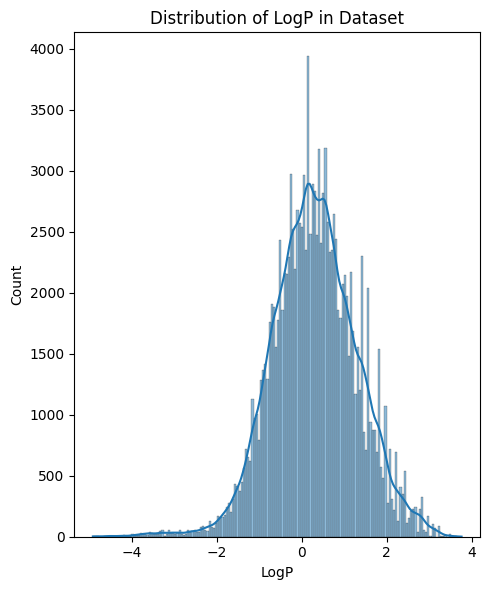

In [47]:
# Distribution of property scores in dataset
plt.figure(figsize=(len(prop_names) * 5, 6))  # Adjust the size as needed

for i, column in enumerate(prop_names):
    plt.subplot(1, len(prop_names), i + 1)  # (1, total number of columns, current column index)
    sns.histplot(qmds[column], kde=True)  # Using seaborn to plot the distribution with a Kernel Density Estimate
    plt.title(f'Distribution of {column} in Dataset')

plt.tight_layout()
plt.show()

# Compute Performance Metrics

In [48]:
def return_valid_smiles(smiles_list):
    '''
    return smiles list with invalid smiles removed
    '''
    valid = []
    for smi in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                valid.append(smi)
        except:
            pass
    return valid

## Global Sample Uniform Prop Vals

In [192]:
# Load QM9 Test Smiles
'''
n_samples = 1000
property_val_range = [-3, 3]

targets = np.random.uniform(low=property_val_range[0], high=property_val_range[1], size=n_samples)
targets = torch.Tensor([[a] for a in targets])

target_props = [float(a[0]) for a in targets]
'''

target_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 2]]
targets = torch.Tensor( [[a] for a in target_props])
num_to_sample = len(target_props)



In [203]:
print('Sampling SD_LSTM Model with Random Uniform Targets')
sd_lstm_global_sample_smiles = sd_lstm_sampler.sample(model=sd_lstm_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=100)
assert(len(sd_lstm_global_sample_smiles) == num_to_sample)

Sampling SD_LSTM Model with Random Uniform Targets


In [199]:
print('Sampling SD_LSTM Model with Random Uniform Targets')
lstm_global_sample_smiles = lstm_sampler.sample(model=lstm_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=100)
assert(len(lstm_global_sample_smiles) == num_to_sample)

Sampling SD_LSTM Model with Random Uniform Targets


In [223]:
print('Sampling VAE Model with Random Uniform Targets')
vae_global_sample_smiles = vae_sampler.sample(model = vae_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=101)
assert(len(vae_global_sample_smiles) == num_to_sample)

Sampling VAE Model with Random Uniform Targets


  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/model_vanilla_vae.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [00:20<00:00,  7.52it/s]


In [226]:
print('Sampling SD VAE Model with Random Uniform Targets')
sd_vae_global_sample_smiles = sd_vae_sampler.sample(model = sd_vae_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=99)
assert(len(sd_vae_global_sample_smiles) == num_to_sample)


Sampling SD VAE Model with Random Uniform Targets


  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/./SD_VAE/model_sd_vae.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
/home/chrome/Code/MolGen/my_code/./SD_VAE/sd_vae_sampler.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  raw_logits = torch.tensor(model.state_decoder(latent_points, properties)) # .permute(1, 0, 2)
100%|██████████| 157/157 [00:47<00:00,  3.34it/s]


In [227]:
lstm_global_properties = props_from_smiles(lstm_global_sample_smiles)
sd_lstm_global_properties = props_from_smiles(sd_lstm_global_sample_smiles)
vae_global_properties = props_from_smiles(vae_global_sample_smiles)
sd_vae_global_properties = props_from_smiles(sd_vae_global_sample_smiles)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 6406.92it/s]


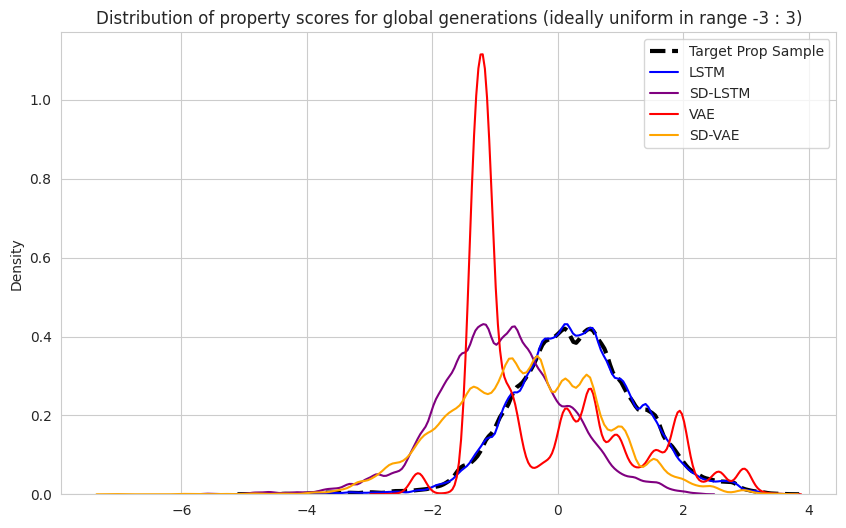

In [228]:
plt.figure(figsize=(10, 6))

sns.kdeplot(target_props, color="black", label='Target Prop Sample', bw_adjust=0.5, linestyle="--", linewidth=3 )
sns.kdeplot(lstm_global_properties, color="blue", label='LSTM', bw_adjust=0.5)
sns.kdeplot(sd_lstm_global_properties, color="purple", label='SD-LSTM', bw_adjust=0.5)
sns.kdeplot(vae_global_properties, color="red", label='VAE', bw_adjust=0.5)
sns.kdeplot(sd_vae_global_properties, color="orange", label='SD-VAE', bw_adjust=0.5)

pval0 = property_val_range[0]
pval1 = property_val_range[1]

plt.title(f'Distribution of property scores for global generations (ideally uniform in range {pval0} : {pval1})')
plt.legend()
plt.show()

## Sample Metrics
Validity, uniqeness, novelty

In [229]:
lstm_metrics = amina_metrics(lstm_global_sample_smiles, train_smiles)
sd_lstm_metrics = amina_metrics(sd_lstm_global_sample_smiles, train_smiles)
vae_metrics = amina_metrics(vae_global_sample_smiles, train_smiles)
sd_vae_metrics = amina_metrics(sd_vae_global_sample_smiles, train_smiles)

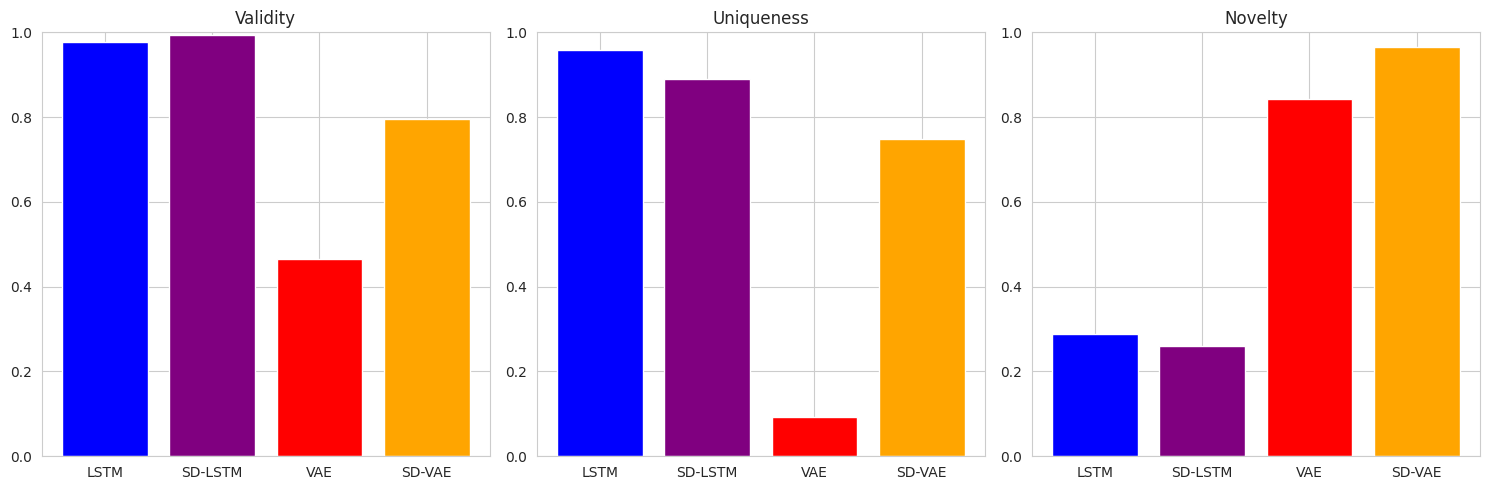

In [230]:
models = ['LSTM', 'SD-LSTM', 'VAE', 'SD-VAE']
metrics = ['Validity', 'Uniqueness', 'Novelty']
data = {
    'Validity': [lstm_metrics[0], sd_lstm_metrics[0], vae_metrics[0], sd_vae_metrics[0]],
    'Uniqueness': [lstm_metrics[1], sd_lstm_metrics[1], vae_metrics[1], sd_vae_metrics[1]],
    'Novelty': [lstm_metrics[2], sd_lstm_metrics[2], vae_metrics[2], sd_vae_metrics[2]]
}

# Plotting
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for ax, metric in zip(axes, metrics):
    ax.bar(models, data[metric], color=['blue', 'purple', 'red', 'orange'])
    ax.set_title(metric)
    ax.set_ylim(0, 1)  # Adjust based on your metric score range

plt.tight_layout()
plt.show()

## Property Metrics

In [231]:
lstm_p_metrics = property_metrics(lstm_global_sample_smiles, targets, prop_names = ['LogP'])
sd_lstm_p_metrics = property_metrics(sd_lstm_global_sample_smiles, targets, prop_names = ['LogP'])
vae_p_metrics = property_metrics(vae_global_sample_smiles, targets, prop_names = ['LogP'])
sd_vae_p_metrics = property_metrics(sd_vae_global_sample_smiles, targets, prop_names = ['LogP'])

/tmp/ipykernel_2094710/3148008902.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')
/tmp/ipykernel_2094710/3148008902.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')


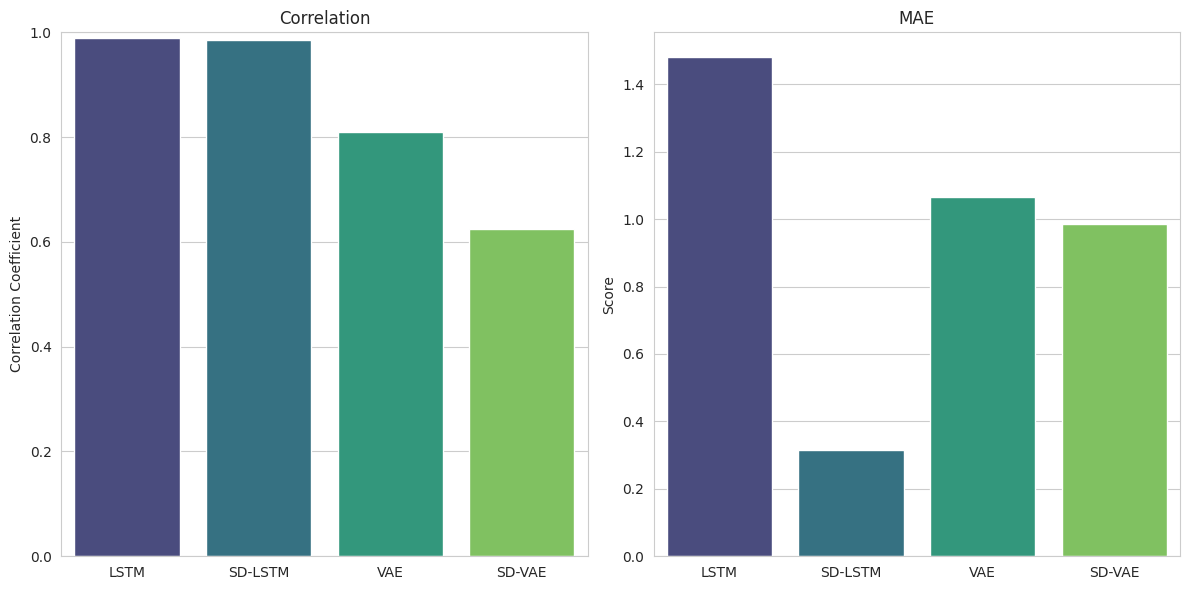

In [234]:
models = ['LSTM', 'SD-LSTM', 'VAE', 'SD-VAE']
metrics_data = {
    'Correlation': {
        'LSTM': lstm_p_metrics[0][0],
        'SD-LSTM': sd_lstm_p_metrics[0][0],
        'VAE': vae_p_metrics[0][0],
        'SD-VAE': sd_vae_p_metrics[0][0]
    },
    'MAE': {
        'LSTM': float(lstm_p_metrics[1][0]),
        'SD-LSTM': float(sd_lstm_p_metrics[1][0]),
        'VAE': float(vae_p_metrics[1][0]),
        'SD-VAE': float(sd_vae_p_metrics[1][0])
    }
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("whitegrid")

for ax, (metric, values) in zip(axes, metrics_data.items()):
    sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')
    ax.set_title(metric)
    ax.set_ylabel('Score' if metric == 'MAE' else 'Correlation Coefficient')
    ax.set_ylim(0, 1 if metric == 'Correlation' else None)  # Adjust the y-axis limit for correlation

plt.tight_layout()
plt.show()

## Visualise sample of smiles

In [169]:

'''
del sys.modules['evaluation_utils']
import importlib
importlib.invalidate_caches()
from evaluation_utils import amina_metrics, property_metrics, plot_smiles
'''


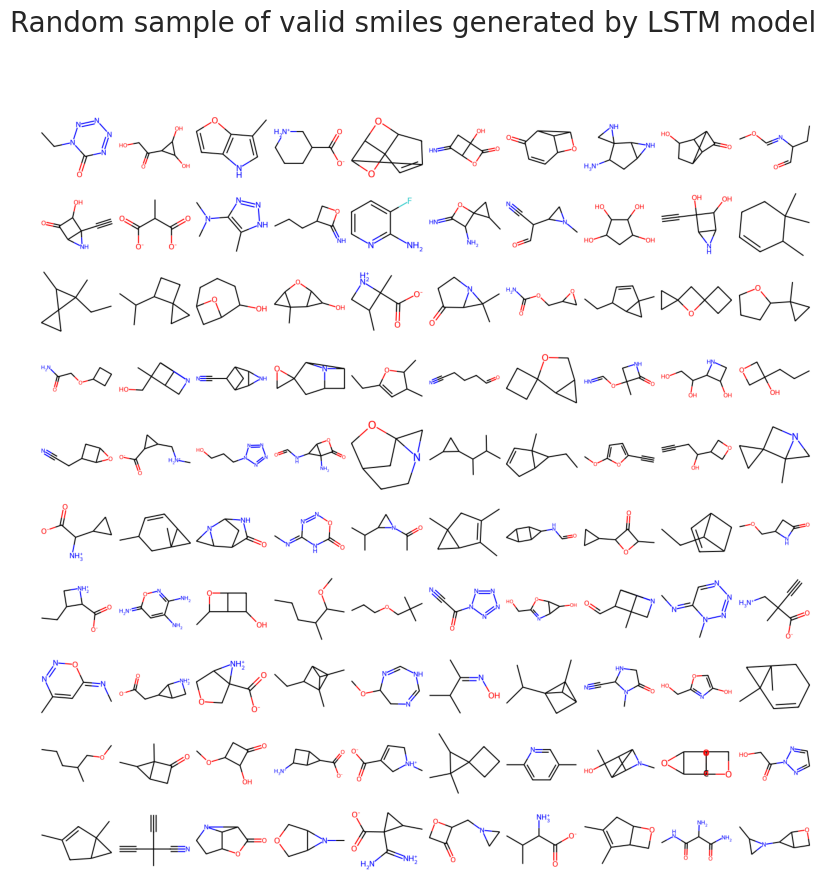

In [170]:
plot_smiles(lstm_global_sample_smiles, title="Random sample of valid smiles generated by LSTM model")


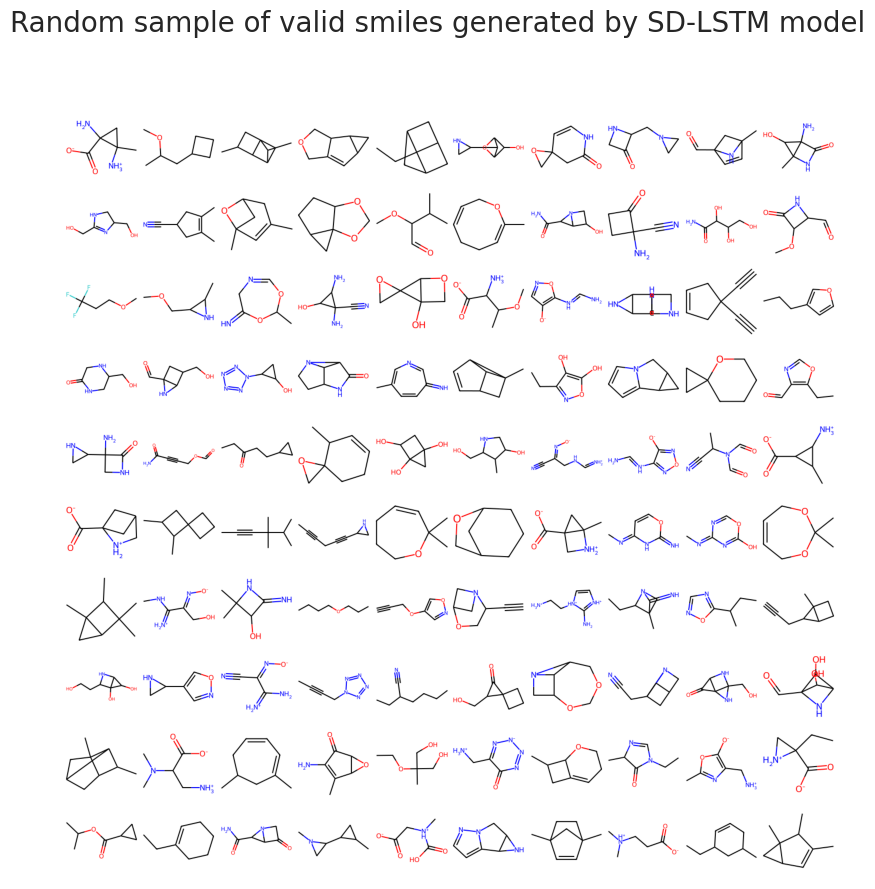

In [171]:
plot_smiles(sd_lstm_global_sample_smiles, title="Random sample of valid smiles generated by SD-LSTM model")


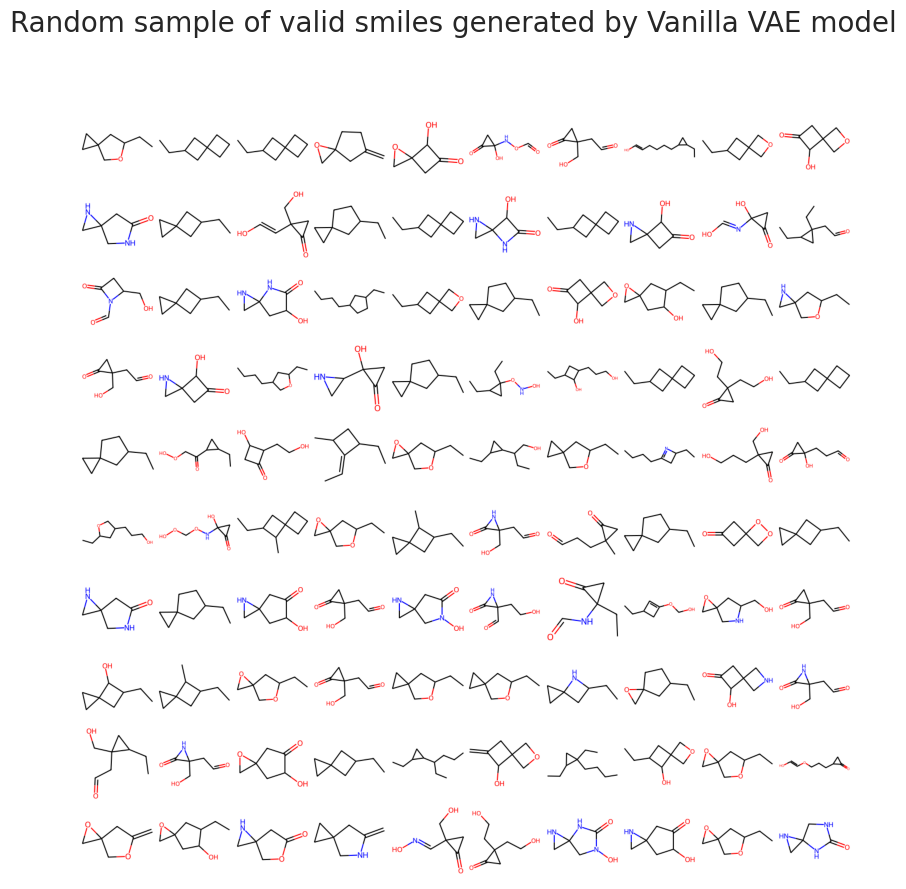

In [172]:
plot_smiles(vae_global_sample_smiles, title="Random sample of valid smiles generated by Vanilla VAE model")


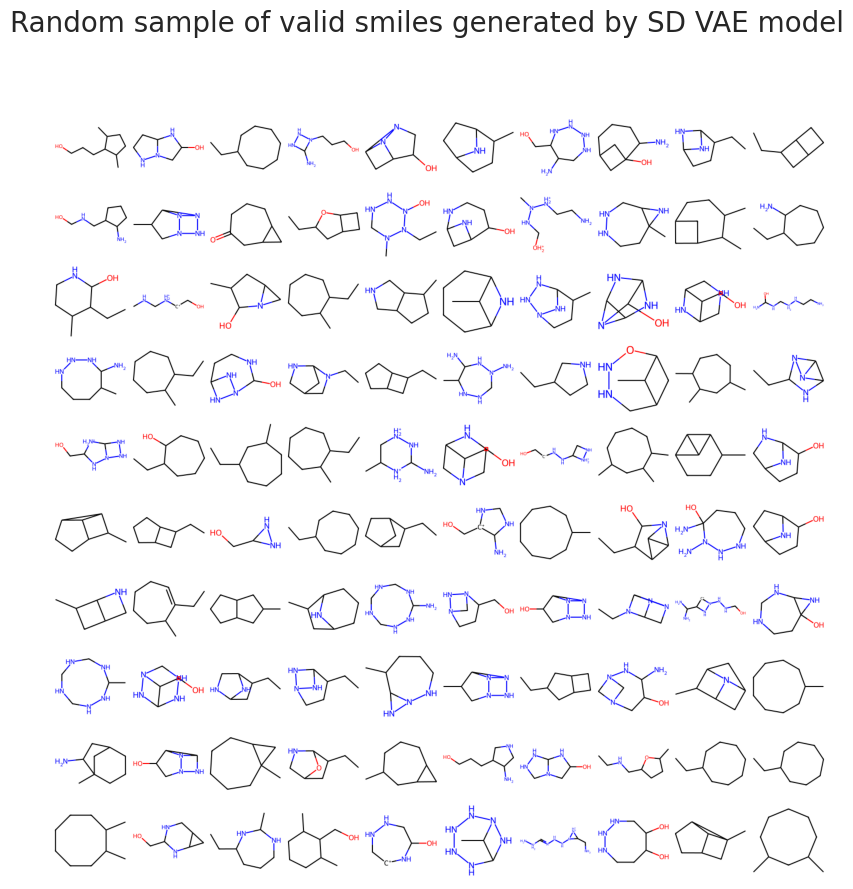

In [173]:
plot_smiles(sd_vae_global_sample_smiles, title="Random sample of valid smiles generated by SD VAE model")

# Performance as a Funct. of Target Value

In [165]:
property_steps = np.arange(-3, 3, 0.1)
samp_per_step = 200

In [50]:
print('Computing for LSTM')

# Sample LSTM at prop steps
lstm_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'diversity': [],
    'novelty':[]
    }


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = []
    smiles = lstm_sampler.sample(model=lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)

    missing = n_samples - len(smiles)
    smiles += ['ERROR' * missing]

    validity, unique_pct, diversity, novelty = compute_all_metrics(smiles, props, list(qmds['SMILES']), corr=False)
    lstm_pstep_smiles['validity'].append(validity)
    lstm_pstep_smiles['unique_pct'].append(unique_pct)
    lstm_pstep_smiles['diversity'].append(diversity)
    lstm_pstep_smiles['novelty'].append(novelty)

print('Computing for SD-LSTM')


# Now for sd_lstm
sd_lstm_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'diversity': [],
    'novelty':[]
    }


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = []
    # Unlike the uniform sample this one tends to fail a few times, so we add fake smiles back in to get the correct numbers for novely ETC

    smiles = sd_lstm_sampler.sample(model=sd_lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)

    missing = n_samples - len(smiles)

    smiles += ['ERROR' * missing]
    validity, unique_pct, diversity, novelty = compute_all_metrics(smiles, props, list(qmds['SMILES']), corr=False)

    sd_lstm_pstep_smiles['validity'].append(validity)
    sd_lstm_pstep_smiles['unique_pct'].append(unique_pct)
    sd_lstm_pstep_smiles['diversity'].append(diversity)
    sd_lstm_pstep_smiles['novelty'].append(novelty)

print('Computing for VAE')


# Now for sd_lstm
vae_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'diversity': [],
    'novelty':[]
    }


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = []
    # Unlike the uniform sample this one tends to fail a few times, so we add fake smiles back in to get the correct numbers for novely ETC

    smiles = vae_sampler.sample(model=vae_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)

    missing = n_samples - len(smiles)

    smiles += ['ERROR' * missing]
    validity, unique_pct, diversity, novelty = compute_all_metrics(smiles, props, list(qmds['SMILES']), corr=False)

    vae_pstep_smiles['validity'].append(validity)
    vae_pstep_smiles['unique_pct'].append(unique_pct)
    vae_pstep_smiles['diversity'].append(diversity)
    vae_pstep_smiles['novelty'].append(novelty)


print('Computing for SD-VAE')

# Now for sd_lstm
sd_vae_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'diversity': [],
    'novelty':[]
    }

for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = []
    # Unlike the uniform sample this one tends to fail a few times, so we add fake smiles back in to get the correct numbers for novely ETC

    smiles = sd_vae_sampler.sample(model=sd_vae_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)

    missing = n_samples - len(smiles)

    smiles += ['ERROR' * missing]
    validity, unique_pct, diversity, novelty = compute_all_metrics(smiles, props, list(qmds['SMILES']), corr=False)

    sd_vae_pstep_smiles['validity'].append(validity)
    sd_vae_pstep_smiles['unique_pct'].append(unique_pct)
    sd_vae_pstep_smiles['diversity'].append(diversity)
    sd_vae_pstep_smiles['novelty'].append(novelty)


Computing for LSTM


  0%|          | 0/60 [00:00<?, ?it/s]

Converting to canonical smiles:


100%|██████████| 201/201 [00:00<00:00, 4592.78it/s]


Checking validity and computing fingerprints


  2%|▏         | 1/60 [00:11<11:00, 11.19s/it]

Computing pairwise similarities
Converting to canonical smiles:


100%|██████████| 201/201 [00:00<00:00, 7307.40it/s]


Checking validity and computing fingerprints


  3%|▎         | 2/60 [00:22<10:38, 11.01s/it]

Computing pairwise similarities
Converting to canonical smiles:


100%|██████████| 201/201 [00:00<00:00, 4401.85it/s]


Checking validity and computing fingerprints


  5%|▌         | 3/60 [00:34<11:02, 11.63s/it]

Computing pairwise similarities
Converting to canonical smiles:


100%|██████████| 201/201 [00:00<00:00, 4787.01it/s]


Checking validity and computing fingerprints


  7%|▋         | 4/60 [00:46<10:52, 11.64s/it]

Computing pairwise similarities


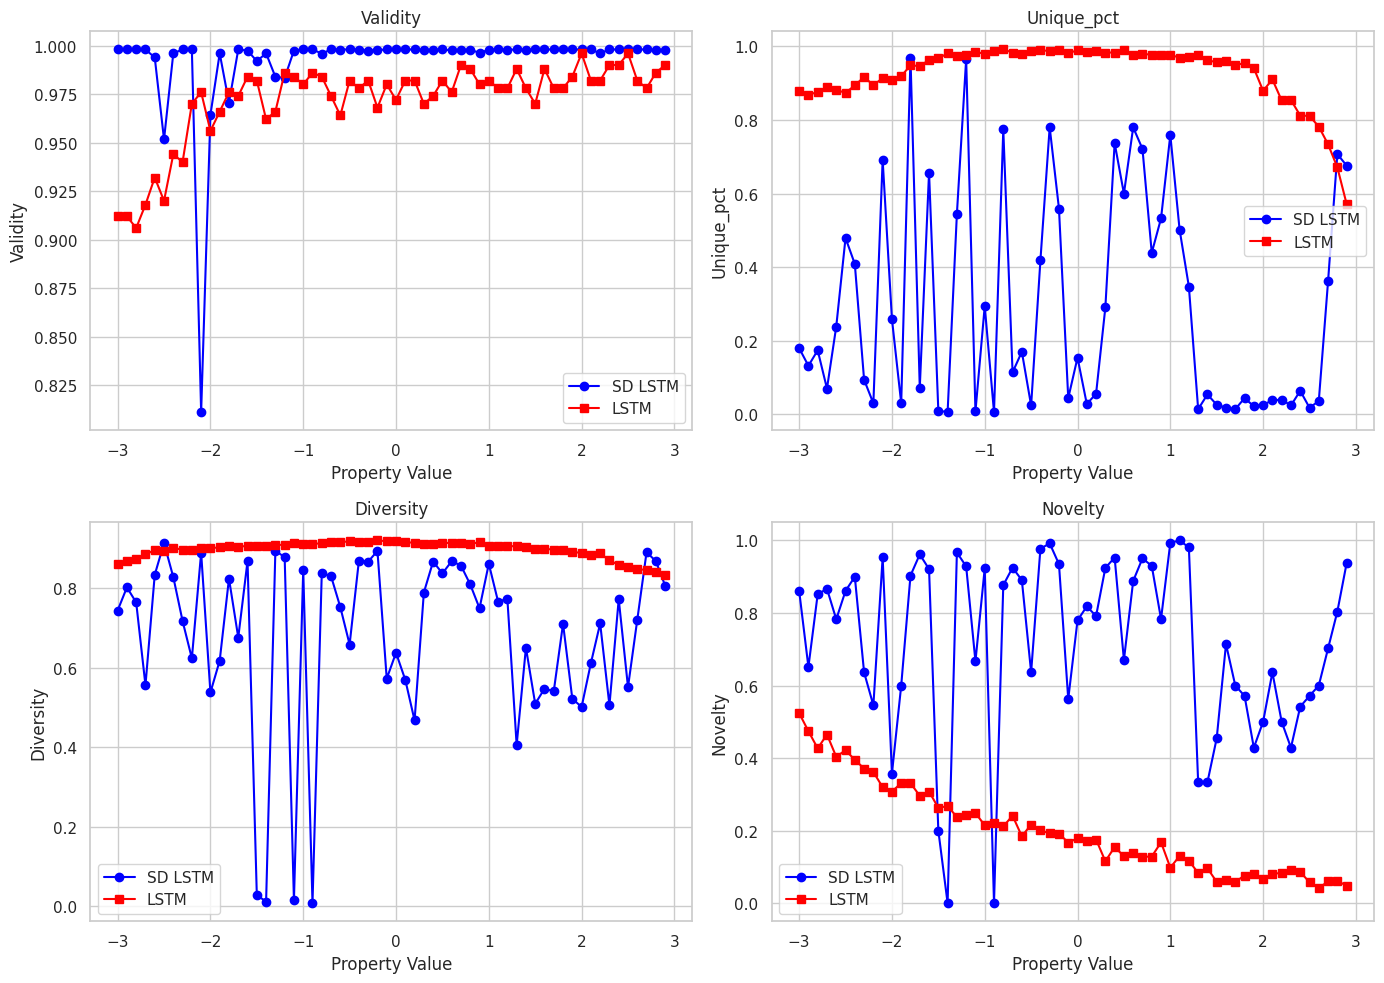

In [150]:
# Assume we have properties for both models in sd_lstm_pstep_smiles and lstm_pstep_smiles
keys = ['validity', 'unique_pct', 'diversity', 'novelty']

plt.figure(figsize=(14, 10))

for i, key in enumerate(keys, 1):
    plt.subplot(2, 2, i)
    plt.plot(property_steps, sd_lstm_pstep_smiles[key], label='SD LSTM', marker='o', linestyle='-', color = 'blue')
    plt.plot(property_steps, lstm_pstep_smiles[key], label='LSTM', marker='s', linestyle='-', color='red')
    plt.plot(property_steps, vae_pstep_smiles[key], label='VAE', marker='o', linestyle='-', color = 'yellow')
    plt.plot(property_steps, sd_vae_pstep_smiles[key], label='SD-VAE', marker='s', linestyle='-', color='orange')
    
    
    plt.title(key.capitalize())
    plt.xlabel('Property Value')
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [160]:
# Plot conditional generation performance

property_steps = np.arange(-3, 3, 0.5)
samp_per_step = 100

lstm_steps_properties = []
lstm_steps_stats =  {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

sd_lstm_steps_properties = []
sd_lstm_steps_stats = {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

vae_steps_properties = []
vae_steps_stats = {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

sd_vae_steps_properties = []
sd_vae_steps_stats = {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

for p_val in tqdm(property_steps):
    # SD-LSTM
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = sd_lstm_sampler.sample(model=sd_lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)
    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    sd_lstm_steps_properties.append(properties)
    sd_lstm_steps_stats['Failed to decode'].append(missing)
    sd_lstm_steps_stats['Invalid Smiles'].append(invalid)
    sd_lstm_steps_stats['Valid'].append(samp_per_step - missing - invalid)


    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = lstm_sampler.sample(model=lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)
    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    lstm_steps_properties.append(properties)
    lstm_steps_stats['Failed to decode'].append(missing)
    lstm_steps_stats['Invalid Smiles'].append(invalid)
    lstm_steps_stats['Valid'].append(samp_per_step - missing - invalid)


100%|██████████| 9/9 [01:08<00:00,  7.57s/it]


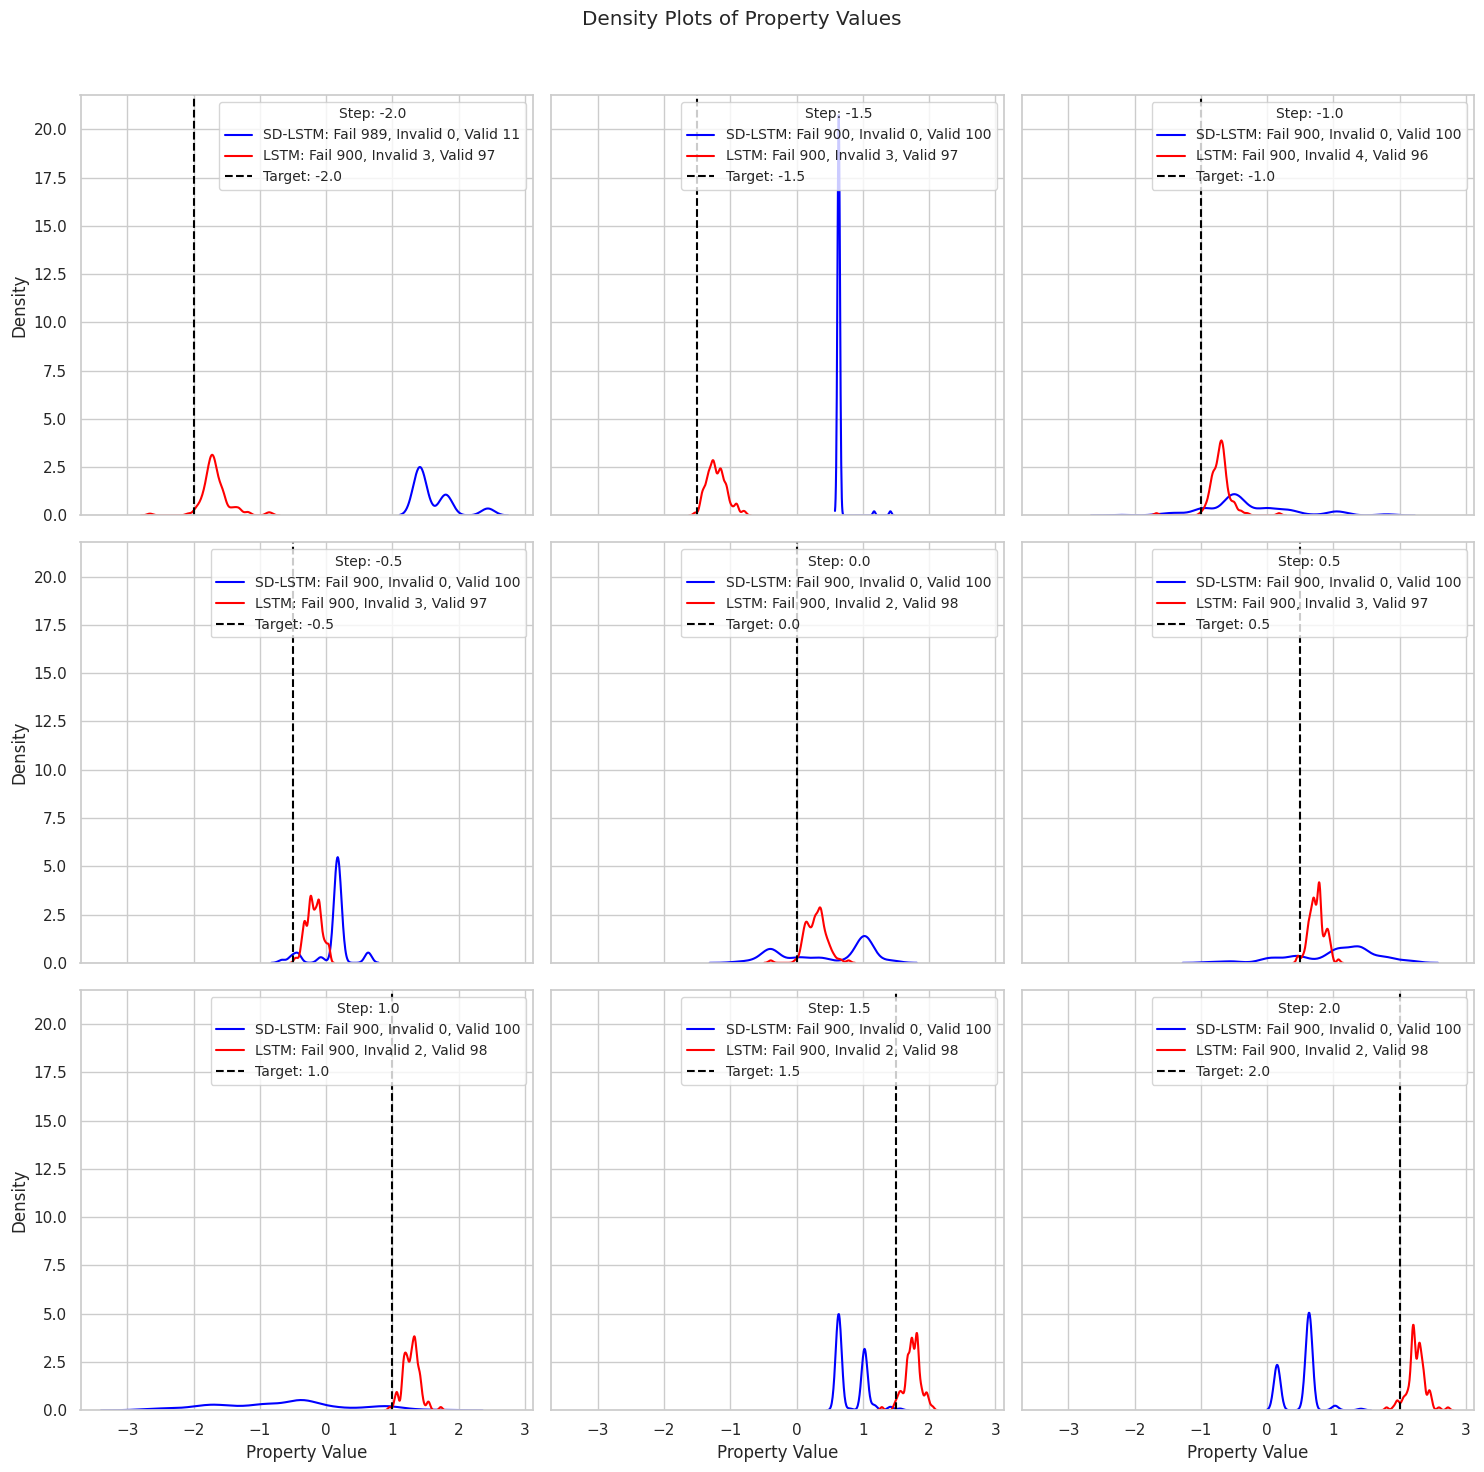

In [161]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Density Plots of Property Values')

# Flatten the axes for easy iteration
axes_flat = axes.flatten()

# Loop through each property step and create the corresponding plot
for i, p_val in enumerate(property_steps):
    ax = axes_flat[i]
    
    # Plot density for SD-LSTM
    if sd_lstm_steps_properties[i]:  # Check if not empty
        sns.kdeplot(sd_lstm_steps_properties[i], ax=ax, color='blue', label='SD-LSTM', bw_adjust=0.5)
    
    # Plot density for LSTM
    if lstm_steps_properties[i]:  # Check if not empty
        sns.kdeplot(lstm_steps_properties[i], ax=ax, color='red', label='LSTM', bw_adjust=0.5)
    
    # Vertical line for the target property value
    ax.axvline(x=p_val, color='black', linestyle='--', label=f'Target: {p_val}')
    
    # Adding legend
    ax.legend(title=f'Step: {p_val}', loc='upper right', fontsize='small', title_fontsize='small', 
              labels=[
                  f'SD-LSTM: Fail {sd_lstm_steps_stats["Failed to decode"][i]}, Invalid {sd_lstm_steps_stats["Invalid Smiles"][i]}, Valid {sd_lstm_steps_stats["Valid"][i]}',
                  f'LSTM: Fail {lstm_steps_stats["Failed to decode"][i]}, Invalid {lstm_steps_stats["Invalid Smiles"][i]}, Valid {lstm_steps_stats["Valid"][i]}',
                  f'Target: {p_val}'
              ])

    # Setting labels for each subplot
    ax.set_xlabel('Property Value')
    ax.set_ylabel('Density')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()